In [1]:
# General Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
import warnings
import scipy.spatial
from scipy import stats
import itertools
warnings.filterwarnings('ignore')


# PyPair imports
from pypair.association import binary_binary
from pypair.contingency import BinaryTable
from pypair.association import categorical_categorical
from pypair.contingency import CategoricalTable
from pypair.association import continuous_continuous
from pypair.association import binary_continuous
from pypair.biserial import Biserial


# See entire Dataframes
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

In [2]:
# I/O Stuff
DATA_FILENAME = "csdh_clean.csv"
DATA_FILEPATH = "/Users/callum/Uni/GitHubRepos/surviving-the-icu/datasets/drain_data/" + DATA_FILENAME
csdh = pd.read_csv(DATA_FILEPATH)

In [3]:
len(csdh[(csdh['recurrence'] == 1) & (csdh['drain'] == 1)]) / csdh[(csdh['drain'] == 1)].shape[0] * 100

7.717041800643088

In [4]:
len(csdh[(csdh['recurrence'] == 1) & (csdh['drain'] == 0)]) / csdh[(csdh['drain'] == 0)].shape[0] * 100

17.073170731707318

In [5]:
# Mapping bedrest to categorical variable
csdh['bedrest'] = csdh['bedrest'].map({'None':0, '<12hrs':1, '12-24hrs':2, '25-48hrs':3, '>48hrs':4})

In [6]:
# Seperating columns of csdh by variable type

# Binary cols
bin_cols = ['diabetes', 'dementia', 'copd', 'stroke', 'ihd', 'arrhythmia', 'epilepsy',
            'shunt', 'malignancy', 'metalvalve', 'headinjury', 'adm_cogimpair', 'adm_incontinence',
            'adm_gait', 'adm_dysphasia', 'adm_headache', 'adm_facialdroop', 'antithrombotics', 
            'antiplatelet', 'membranes', 'steroid', 'drain', 'recurrence', 'bilateral'
           ]
# Continuous cols
cont_cols = ['age', 'inr', 'platelet', 'midlineshift','thickness_sum', 'thickness_r', 'thickness_l',
             'thickness_cleaned', 'thickness_avg', 'thickness_max'
            ]
# Categorical cols
cat_cols = [i for i in list(csdh.columns) if i not in (cont_cols+bin_cols)]

cont_cols.remove('thickness_cleaned')

csdh_cat = csdh[cat_cols]
csdh_cont = csdh[cont_cols]
csdh_bin = csdh[bin_cols]

---
## Binary-Binary: 
* The $\chi^2$ test statistic is computed for the hypothesis test of independence between the observed frequencies in the contingency table.
* $\chi^2$ has 1 DOF for 2x2 contingency tables.
* For significant dependence between two binary variables(i.e 95% significance), we only look at variables where $\chi^2 > 3.841$

**Relevant Relationships:**
* **antiplatelet** - stroke 40.84
* ihd - **antiplatelet** 38.043
* diabetes - ihd 38.043
* copd - membranes 21.370
* **metalvalve - recurrence** 13.5093
* arrhythmia - ihd 11.926
* **drain - recurrence** 11.531
* **ihd - recurrence** 6.973
* **drain - adm_cogimpair** 4.573
* **drain - adm_incontinence** 3.944

In [7]:
def get_chisq_pval(chisq, dof):
    """
       Input: value of chisq
       Output: corresponding chisq p-value (dof)
    """
    return 1 - stats.chi2.cdf(chisq, dof)

In [8]:
# Use PyPair to compute chisq between all binary variables
chisq = lambda a, b: binary_binary(a, b, measure='chisq')
chisq_corr = csdh_bin.corr(method=chisq)

# Unstack table intop list
bin_corr_list = chisq_corr.unstack()
bin_corr_list = bin_corr_list.sort_values(kind="quicksort")[::-1]

# Filter out pairs where null hypothesis could not be rejected
sig_mask = bin_corr_list > 3.841
sig_bin = bin_corr_list[sig_mask]

In [9]:
# Form dataframe of chisq and pvals
sig_bin_ps = get_chisq_pval(sig_bin.values, 1)
sig_bin_df = sig_bin.to_frame()
sig_bin_df = sig_bin_df.rename(columns = {0:'chisq'})
sig_bin_df['p_val'] = sig_bin_ps

In [10]:
sig_bin_df = sig_bin_df.sort_values(by='p_val')

In [11]:
sig_bin_df

,,chisq,p_val
antiplatelet,antithrombotics,316.158104,0.000000e+00
antithrombotics,antiplatelet,316.158104,0.000000e+00
arrhythmia,antithrombotics,122.508344,0.000000e+00
antithrombotics,arrhythmia,122.508344,0.000000e+00
adm_headache,adm_cogimpair,59.632906,1.143530e-14
adm_cogimpair,adm_headache,59.632906,1.143530e-14
antithrombotics,ihd,45.544621,1.492007e-11
ihd,antithrombotics,45.544621,1.492007e-11
antiplatelet,stroke,40.841393,1.650988e-10
stroke,antiplatelet,40.841393,1.650988e-10


--- 
## Categorical-Categorical
* Very little association could be found between the categorical variables.
* We care most about `adm_mrs` and was independent of almost all other categorical variables

In [40]:
cat_cat_df = pd.DataFrame(columns=['pair', 'chisq', 'p_val'])
# Cartesian product of binary and continous variables
combs = itertools.product(cat_cols, cat_cols)


In [41]:
for cat1, cat2 in combs:
    contingency_table = pd.crosstab(csdh[cat1], csdh[cat2])
    chi2, p_val, _, _ = scipy.stats.chi2_contingency(contingency_table)
    if cat1 != cat2:
        cat_cat_df = cat_cat_df.append({'pair':(cat1, cat2), 'chisq':chi2, 'p_val':p_val}, ignore_index=True)

In [42]:
cat_cat_df = cat_cat_df[cat_cat_df['p_val'] < 5e-02].sort_values(by='p_val')

In [43]:
cat_cat_df

,pair,chisq,p_val
216,"(gcs_m, gcs_preop)",1905.058592,0.000000e+00
193,"(gcs_v, gcs_preop)",1792.971690,0.000000e+00
239,"(gcs_preop, gcs_m)",1905.058592,0.000000e+00
238,"(gcs_preop, gcs_v)",1792.971690,0.000000e+00
170,"(gcs_e, gcs_preop)",1192.830289,1.983567e-229
237,"(gcs_preop, gcs_e)",1192.830289,1.983567e-229
530,"(bedrest, hospital)",945.391611,1.068146e-137
45,"(hospital, bedrest)",945.391611,1.068146e-137
168,"(gcs_e, gcs_v)",563.927899,5.298360e-113
191,"(gcs_v, gcs_e)",563.927899,5.298360e-113


---
## Continuous-Continuous
* Can simply use Pearson correlation coefficient, $\rho$.

**Relevant Relationships:**
* age - thickness_sum 0.219
* midlineshift - platelet 0.0978
* gcs_preop - midlineshift -0.174
* midlineshift - thickness_sum -0.1449
* inr - platelet -0.104
* midlineshift - age -0.1
* platelet - thickness_sum -0.0954

In [16]:
def pearsonr_pval(x, y):
    """
        Input: two variables x and y
        Output: p-value of Pearson correaltion
    """
    return scipy.stats.pearsonr(x,y)[1]

In [17]:
cont_corr = csdh_cont.corr(method='pearson')

In [18]:
cont_corr_p = csdh_cont.corr(method=pearsonr_pval)

In [19]:
# Unstack table intop list
cont_corr_list = cont_corr.unstack()
cont_corr_list = cont_corr_list.sort_values(kind='quicksort')[::-1]

cont_corr_p_list = cont_corr_p.unstack()
cont_corr_p_list = cont_corr_p_list.sort_values(kind='quicksort')[::-1]

In [20]:
cont_corr_df = cont_corr_list.to_frame()
cont_corr_df = cont_corr_df.rename(columns = {0:'rho'})
cont_corr_df['p_val'] = cont_corr_p_list

In [21]:
sig_cont_corr_df = cont_corr_df.loc[cont_corr_df['p_val'] <= 5e-02].sort_values(by='p_val')

In [22]:
sig_cont_corr_df

,,rho,p_val
thickness_avg,thickness_max,0.946231,0.000000e+00
thickness_max,thickness_avg,0.946231,0.000000e+00
thickness_sum,thickness_max,0.764317,1.012790e-143
thickness_max,thickness_sum,0.764317,1.012790e-143
thickness_sum,thickness_avg,0.614128,1.948110e-78
thickness_avg,thickness_sum,0.614128,1.948110e-78
thickness_l,thickness_r,-0.560937,5.720898e-63
thickness_r,thickness_l,-0.560937,5.720898e-63
thickness_sum,thickness_r,0.518378,1.812146e-52
thickness_r,thickness_sum,0.518378,1.812146e-52


---
## Binary-Categorical

In [23]:
bin_cat_df = pd.DataFrame(columns=['pair', 'chisq', 'p_val'])
# Cartesian product of binary and continous variables
combs = itertools.product(bin_cols, cat_cols)

In [24]:
for binary, cat in combs:
    contingency_table = pd.crosstab(csdh[binary], csdh[cat])
    chi2, p_val, _, _ = scipy.stats.chi2_contingency(contingency_table)
    bin_cat_df = bin_cat_df.append({'pair':(binary, cat), 'chisq':chi2, 'p_val':p_val}, ignore_index=True)

In [25]:
bin_cat_df = bin_cat_df[bin_cat_df['p_val'] < 5e-02].sort_values(by='p_val')

In [26]:
bin_cat_df

,pair,chisq,p_val
564,"(bilateral, laterality)",745.000000,1.679985e-162
272,"(adm_cogimpair, gcs_v)",351.241434,9.460918e-75
274,"(adm_cogimpair, gcs_preop)",357.741769,5.571033e-70
131,"(arrhythmia, warfarin)",276.487450,4.375812e-62
419,"(antithrombotics, warfarin)",225.621854,5.372573e-51
26,"(dementia, residence)",148.921829,4.501347e-32
268,"(adm_cogimpair, adm_mrs)",122.919986,7.552183e-25
505,"(drain, hospital)",162.586747,3.885046e-22
567,"(bilateral, burrhole_num)",95.440851,1.884875e-21
469,"(membranes, density)",79.524566,5.388400e-18


---
## Binary-Continuous
* Point biserial correlation coefficient provides a meaninful measure of association between binary and continuous variables

**Relevant Relationships:**
* bilateral - midlineshift -0.434
* arrhythmia - inr 0.239
* membranes - thickness_sum 0.216
* ihd - age 0.207
* antiplatelet - age 0.1510
* **drain - age** 0.1457
* **recurrence, thickness_sum**	0.082071
* **drain, thickness_sum** 0.090699

In [27]:
bin_cont_df = pd.DataFrame(columns=['pair', 'rho', 'p_val'])

In [28]:
# Cartesian product of binary and continous variables
combs = itertools.product(bin_cols, cont_cols)

In [29]:
for binary, cont in combs:
    rho, p_val = scipy.stats.pointbiserialr(csdh[binary], csdh[cont])
    bin_cont_df = bin_cont_df.append({'pair':(binary, cont), 'rho':rho, 'p_val':p_val}, ignore_index=True)

In [30]:
bin_cont_df = bin_cont_df[bin_cont_df['p_val'] < 5e-02].sort_values(by='p_val')

In [31]:
bin_cont_df

,pair,rho,p_val
211,"(bilateral, thickness_sum)",0.542461,3.171358e-58
210,"(bilateral, midlineshift)",-0.434094,1.378411e-35
135,"(adm_headache, age)",-0.318027,5.691382e-19
214,"(bilateral, thickness_avg)",-0.279035,8.628734e-15
213,"(bilateral, thickness_l)",0.260823,4.735562e-13
179,"(membranes, thickness_max)",0.254174,1.896071e-12
178,"(membranes, thickness_avg)",0.253319,2.260122e-12
99,"(adm_cogimpair, age)",0.252826,2.499665e-12
212,"(bilateral, thickness_r)",0.248713,5.753715e-12
46,"(arrhythmia, inr)",0.238748,4.075840e-11




## Drain

### Point Biserial

|Pair | $\rho$ | p value|
|--- | --- | ---|
|(drain, inr)|0.074753|4.137233e-02|
|(drain, thickness_sum)|0.090699|1.326631e-02|
|(drain, age)|0.145738|6.536865e-05|

### $\chi^2$ Contingency

|Pair | $\chi^2$ | p value|
|--- | --- | ---|
|(drain, bedrest)	        |11.456079	|2.188934e-02|
|(drain, adm_mrs)	        |15.218497	|9.468413e-03|
|(drain, optype)	        |20.755575	|3.111602e-05|
|(drain, burrhole_num)	    |20.642463	|3.292654e-05|
|(drain, hospital)	        |162.58674 |3.885046e-22|
|(drain, adm_cogimpair)    |4.573429	|3.247150e-02|
|(drain, recurrence)	    |11.531058	|6.844305e-04|
|(drain, adm_incontinence) |3.924427	|4.758941e-02|



In [32]:
hosp_table = pd.crosstab(csdh['drain'], csdh['hospital'])
hosp_table

hospital,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26
drain,,,,,,,,,,,,,,,,,,,,,,,,,,
0,8,1,2,2,2,37,1,1,0,2,0,0,7,2,1,2,16,1,4,3,3,2,11,2,6,7
1,71,29,26,35,34,46,25,6,51,47,19,22,14,0,15,7,14,38,5,11,3,13,17,24,21,29


In [33]:
mrs_table = pd.crosstab(csdh['drain'], csdh['adm_mrs'])
mrs_table

adm_mrs,0,1,2,3,4,5
drain,,,,,,
0,3,33,17,22,39,9
1,10,86,134,127,206,59


In [34]:
op_table = pd.crosstab(csdh['drain'], csdh['optype'])
op_table

optype,1,2,3
drain,,,
0,101,14,8
1,563,54,5


In [35]:
hole_table = pd.crosstab(csdh['drain'], csdh['burrhole_num'])
hole_table

burrhole_num,1.0,2.0,3.0
drain,,,
0,25,67,3
1,48,431,20


In [36]:
rec_table = pd.crosstab(csdh['drain'], csdh['recurrence'])
rec_table

recurrence,0.0,1.0
drain,,
0,102,21
1,574,48


In [37]:
bed_table = pd.crosstab(csdh['drain'], csdh['bedrest'])
bed_table

bedrest,0,1,2,3,4
drain,,,,,
0,63,12,30,17,1
1,245,39,240,88,10


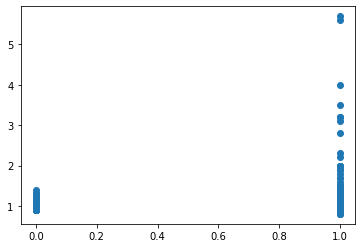

In [38]:
plt.scatter(csdh['drain'], csdh['inr'])
plt.show()

---
## Recurrence

### Point Biserial
|Pair | $\rho$ | p value|
|--- | --- | ---|
|(recurrence, thickness_sum)|	0.082071|	2.508276e-02|

### $\chi^2$ Contingency
|Pair | $\chi^2$ | p value|
|--- | --- | ---|
|(recurrence, gcs_preop)	|28.161209	|3.058233e-03|
|(recurrence, hospital)	|60.398044	|9.212907e-05|
|(recurrence, ihd)|	6.972981|	8.274954e-03|
|(recurrence, drain)| 11.531058	| 6.844305e-04| 
|(recurrence, metalvalve)	|13.509310|	2.373828e-04|

In [39]:
hole_table = pd.crosstab(csdh['recurrence'], csdh['drain_days'])
hole_table

drain_days,1.0,2.0,3.0
recurrence,,,
0.0,151,399,24
1.0,12,34,2
